Emily Wang and Filippos Lymperopoulos | Data Science 2016 | CYOA: sfcrime

Feb 15, 2016

### The process

* Import libraries and training data
* Feature engineering / preprocessing: 
    * Make "useful" combinations of features to give our model; 
    * Also encode categorical things in an intelligent way; 
    * Can choose to only use a subset of features if desired
* Partition your data (cross-validation kfolds, etc)
* Model fit
* Make some predictions
* Compute the logloss score
* Reflect; iterate 

Firstly, let's import some useful libraries and import the data. 

In [1]:
import pandas as pd

from IPython.display import display
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
# from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn.metrics import log_loss
import numpy as np
import pprint as pp

# Convert the Dates column of our provided data from string to datetime format.
train = pd.read_csv('train.csv', parse_dates = ['Dates'])
test = pd.read_csv('test.csv', parse_dates = ['Dates'])

# Print the first 3 rows of the dataframe.
display(train.head(3))

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


### Feature Engineering, Preprocessing

Make a class that will:
* Extract the time features we want to use for the model (e.g. year, season, month, day, etc.)
* Encode categorical variables in a meaningful way: contains a preprocessor that can both transform and inverse_transform the categorical variables
* Return a transformed dataframe to be given to the model
* Maybe: allow for some flexibility with what is in the transformed dataframe (to iterate quickly) (e.g. choosing how many time features you want in this experiment)

In [2]:
# SFP = SFCrime Preprocessor
class SFP():
    def __init__(self, data):
        self.data = data
        self.Y_encoder = preprocessing.LabelEncoder()
    
    # Prepare inputs
    def prep_district(self):
        # one hot encoding
        return pd.get_dummies(self.data.PdDistrict)
    
    def prep_hour(self):
        # a continuous value from 0 to 23
        return self.data.Dates.dt.hour # Gets the hour portion form the "Dates" column
    
    def prep_day(self):
        # one hot encoding
        return pd.get_dummies(self.data.DayOfWeek)
    
    def prep_years(self):
        # beware: 2015 has significantly less incidents than the other years in this dataset.        
        pass
    
    def concat_features(self):
        hour = self.prep_hour()
        day = self.prep_day()
        district = self.prep_district()
        return pd.concat([hour, day, district], axis=1)
    
    # Encode or decode classes
    def encode_Y(self, Y):
        return self.Y_encoder.fit_transform(Y)

    def decode_Y(self, encoded_Y):
        return self.Y_encoder.inverse_transform(encoded_Y)

In [3]:
sfp = SFP(train)
X = sfp.concat_features()
y = sfp.encode_Y(train.Category)

display(X.head())

,Dates,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,23,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


### Partition the data!

In [4]:
# note: this X and Y in particular are from the data in train.csv. See previous section for details.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

### Fit the training data to the algorithm

Decision trees are known to be good at handling categorical data. Let's try using some of the decision tree variations in scikit learn (decision tree, random forest, gradient boost, etc) and tweak some hyperparameters. We might even do some ensemble learning. Oooh shiny!

#### Decision Tree

In [5]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
_ = dtc.fit(X_train, y_train)
y_predictions = dtc.predict_proba(X_test)
dtc_log_loss = log_loss(y_test, y_predictions)

In [6]:
dtc_log_loss 

3.007115993440352

Filippos says he thinks this log loss value of 3.007115993440352 is very deece. Confirmed by looking at the kaggle leaderboards.

#### Random Forest!!

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Using some hyperparameter values from DataQuest mission 75
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=1) 
_ = rf.fit(X_train, y_train)
y_predictions = rf.predict_proba(X_test)
rf_log_loss = log_loss(y_test, y_predictions)

In [8]:
rf_log_loss

3.0111558103212417

#### Stochastic Gradient Descent
[scikit learn cheatsheet advises us to look into SGD classifiers!](http://scikit-learn.org/stable/tutorial/machine_learning_map/)

Understanding SGD:
* yay Andrew Ng ML video
* batch gradient descent (looks at all of the training examples in every iteration)
* stochastic gradient descent (looks at only one training example in every iteration)
    * how well is my hypothesis doing on a single example? for a given theta and x,y pair
* different in the implementation details and making progress towards the minimum

In [9]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", penalty="l2")
_ = sgd.fit(X_train, y_train)
y_predictions = sgd.predict_proba(X_test)
sgd_log_loss = log_loss(y_test, y_predictions)

In [10]:
sgd_log_loss

2.7003337842632695

"Ooooooooooohhhh"  -- Emily and Filippos

#### Naive Bayes


In [37]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
_ = nb.fit(X_train, y_train)
y_nb_predictions = nb.predict_proba(X_test)
nb_log_loss = log_loss(y_test, y_nb_predictions)

In [38]:
nb_log_loss

2.609770164645326

"Ooooooooooohhhh" (again)  -- Emily and Filippos

#### A baseline

What's the log loss for a model that just predicts that all new data is the most common crime type ('LARCENCY/THEFT') ?


In [190]:
decoded = sfp.decode_Y(sgd.classes_)

# replace with something more elegant later; had some weird things to debug 
for x in range(len(decoded)):
    if decoded[x] == "LARCENY/THEFT":
        popular_index = x

# baseline_row = np.zeros(39)
# baseline_row[popular_index] = 1

baseline_y_pred = np.zeros((y_test.shape[0], 39))
baseline_y_pred[:,16] = 1

baseline_log_loss = log_loss(y_test, baseline_y_pred)

In [193]:
baseline_log_loss

27.658162800015461

As expected, this baseline model that assumes all unseen incidents are LARCENY/THEFT does terribly. This should be a helpful comparison for our classifiers above.

#### Next steps

ASAP:
* ~~prepare a submission to kaggle~~
* Visualization of performance of the different models (include an ensemble learning result in here too)
* ~~Comparison of log loss to the "predict the most common thing" baseline model (predict all unseen incidents to be LARCENY/THEFT)~~
* *10 fold validation + mean and standard deviation for the metrics* - Emily
* ~~log loss on each separate class (turn the multi class problem into 39 binary problems)~~
    * --> discover more specifically which things the model predicts well and not so well 
    * --> more exploration and feature engineering in hopes of resolving the difference in performance between crime classes


Backlog:
* ~~explanation on SGD black box~~
* ~~How to translate the 39-element outputs into more "human readable" outputs: TOP5~~
* *Creative approaches to ensemble learning!* - Filippos 
* ~~Naive Bayes~~
* Try playing with hyperparameters; see how changes in those values impact the logloss, and plot them (hyperparameter value vs. log loss)

Process comments:
* We're relatively happy with our current preprocessor to pause on the feature engineering and do experiments with the predictive models; we'll cycle back to the feature engineering if there's time and interest. :)

Feb 16, 2016

### Trying it out on the test set

Preparing our inputs (the X matrix): This should all look very familiar to the cells in the previous sections.

Be careful of your variable names!!

In [16]:
# sfp_submission will be used to preprocess the data from test.csv
sfp_submission = SFP(test) 
X_submission = sfp_submission.concat_features() 

# Sanity check: These should not be the same, because X is from train.csv and X_submission is from test.csv
display(X.head())
display(X_submission.head())

,Dates,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,23,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


,Dates,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,23,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,23,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,23,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,23,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,23,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [17]:
# As a first pass, usnig the sgd we trained earlier in the notebook
y_predictions_submission = sgd.predict_proba(X_submission)

In [18]:
submission_header = sfp.decode_Y(sgd.classes_).tolist()
df_submission = pd.DataFrame(y_predictions_submission)
display(df_submission.head())
filename = "model5_sgd.csv"
# df_submission.to_csv(filename, index=True, index_label="Id", header=submission_header)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.001809,0.050622,0.000521,0.000056,0.071214,0.001588,0.004362,0.099993,0.001679,0.000408,...,0.000666,0.002166,0.000115,0.014865,4.122625e-07,0.002346,0.010243,0.099175,0.018914,0.011439
1,0.001809,0.050622,0.000521,0.000056,0.071214,0.001588,0.004362,0.099993,0.001679,0.000408,...,0.000666,0.002166,0.000115,0.014865,4.122625e-07,0.002346,0.010243,0.099175,0.018914,0.011439
2,0.000600,0.029403,0.000476,0.000031,0.070650,0.001859,0.003960,0.069939,0.001730,0.000397,...,0.000493,0.002711,0.000103,0.008132,3.542536e-07,0.002078,0.007652,0.063125,0.015332,0.003955
3,0.001032,0.049713,0.000571,0.000051,0.068561,0.001479,0.004871,0.064422,0.001598,0.000447,...,0.000717,0.002403,0.000130,0.014045,4.264281e-07,0.001857,0.012848,0.151420,0.012302,0.008885
4,0.001032,0.049713,0.000571,0.000051,0.068561,0.001479,0.004871,0.064422,0.001598,0.000447,...,0.000717,0.002403,0.000130,0.014045,4.264281e-07,0.001857,0.012848,0.151420,0.012302,0.008885


In [19]:
df_submission.shape # should have 884262 predictions

(884262, 39)

This model received a log loss score of 2.70463 (rank 857 on the kaggle leaderboards).

### Supplemental notes on how we're preparing submission for kaggle

* a header that describes the different categories... 
* id column (?)
* each row is a 39-element vector (probablity for each of the 39 classes for each incident)

#### How do we make the header from our predict_proba output?

According to the scikit learn documentation, the output is: "The class probabilities of the input samples. The order of the classes corresponds to that in the attribute classes_." [Also, thanks stackoverflow for an example.](http://stackoverflow.com/questions/16858652/how-to-find-the-corresponding-class-in-clf-predict-proba/16859091#16859091)

In [20]:
print(y_predictions_submission[0])
print(sgd.classes_) 
print(sfp.decode_Y(sgd.classes_)) # human readable

[  1.80885600e-03   5.06217664e-02   5.21420559e-04   5.55240732e-05
   7.12139792e-02   1.58834381e-03   4.36221428e-03   9.99933111e-02
   1.67876161e-03   4.07881317e-04   1.06878663e-04   1.71329406e-03
   6.64602262e-04   7.70239747e-03   6.04011922e-04   1.10289901e-03
   2.49413071e-01   1.09520936e-02   1.47554328e-03   1.47796173e-02
   5.93034121e-02   1.98344334e-01   1.94216861e-05   1.17910028e-04
   2.07942225e-03   9.16850137e-03   1.73778213e-03   4.65547214e-02
   1.97833511e-03   6.65919728e-04   2.16619888e-03   1.14727301e-04
   1.48648584e-02   4.12262470e-07   2.34649890e-03   1.02434863e-02
   9.91745392e-02   1.89140145e-02   1.14390377e-02]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 

I then prototyped some code to prepare the submission csv. Uncomment if you want to investigate further. (It's currently commented out to prevent the creation of a csv by accident.)

In [21]:
# Making a test_submission 
# subset = y_predictions[0:10]
# df = pd.DataFrame(subset)
# submission_header = sfp.decode_Y(sgd.classes_).tolist()
# csv = df.to_csv("test_submission.csv", index=True, index_label="Id", header=submission_header)

### Making the outputs human readable

Let's print out the top 5 probabilities for a single incident.

In [22]:
a = y_predictions[0]

# # strategy from http://stackoverflow.com/questions/6910641/how-to-get-indices-of-n-maximum-values-in-a-numpy-array
ind = np.argpartition(a, -5)[-5:]
top5_words = sfp.decode_Y(ind)
top5 = {}
for i in range(len(ind)):
    top5[top5_words[i]] = a[ind[i]] 

import operator
sorted_top5 = sorted(top5.items(), key=operator.itemgetter(1), reverse=True)
print sorted_top5

# Visualize for a given incident

[('DRUG/NARCOTIC', 0.22952135351915204), ('OTHER OFFENSES', 0.15045548579077567), ('LARCENY/THEFT', 0.11885207094595898), ('ASSAULT', 0.10955692433372424), ('NON-CRIMINAL', 0.094745908698342901)]


In [23]:
# TODO: plot category vs. probability

### Ensembling

### Running several trials and summary statistics for those trials

### Comparing different implementations (change in performance vs. frequency) 

### Examining model mistakes
* Finding the differences between what it does well and what it does not as well

### Making the outputs human readable
* Top 5?

### Per-Class Log Loss

We have a suspicion that our model is doing better on the classes which have more incidents. i.e. LARCENY/THEFT has many thousands more data points than ASSAULT. To investigate which classes our current multi-class model does poorly on, we are computing the per-class log loss for each class. 

This involves some processing of the y vectors into 1s and 0s. 

In [51]:
# y_nb_predictions

# Computing the per-class log loss for class 16 (LARCENY/THEFT)
y_test_per_class = pd.DataFrame({
        "class" : y_test
    })
y_test_per_class.loc[y_test_per_class["class"] == 16, "class"] = 1
y_test_per_class.loc[y_test_per_class["class"] != 16, "class"] = 0

In [194]:
per_class_log_loss = []
for c in range(0, 39):
    current_class = y_predictions[:, c]
    not_current_class = 1 - y_predictions[:, c]

    df = pd.DataFrame({
            "truth" : y_test,
            "current_class" : current_class,
            "not_current_class" : not_current_class
        })

    df.loc[df["truth"] == c, "binary_truth"] = 1
    df.loc[df["truth"] != c, "binary_truth"] = 0

    y_binary_truth = np.array(df["binary_truth"])
    y_binary_predictions = np.array(pd.concat([df["not_current_class"], df["current_class"]], axis=1))

    current_class_log_loss = log_loss(y_binary_truth, y_binary_predictions)
    per_class_log_loss.append(current_class_log_loss)

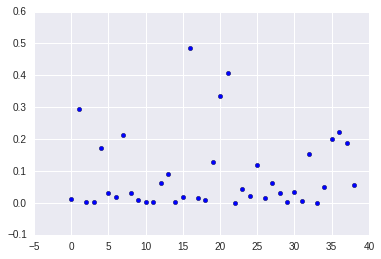

In [143]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

labels = sfp.decode_Y(nb.classes_).tolist()

plt.scatter(range(0, 39), per_class_log_loss) # TODO: label axes, words on the x axis.
plt.show()

So... this plot confuses us because the categories with the most data points (LARCENY/THEFT and ASSAULT) have the highest values??

In [148]:
per_class_log_loss = []
for c in range(0, 39):
    current_class = y_predictions[:, c]
    not_current_class = 1 - y_predictions[:, c]

    df = pd.DataFrame({
            "truth" : y_test,
            "current_class" : current_class,
            "not_current_class" : not_current_class
        })

    df.loc[df["truth"] == c, "binary_truth"] = 1
    df.loc[df["truth"] != c, "binary_truth"] = 0

    y_binary_truth = np.array(df["binary_truth"])
    y_binary_predictions = np.array(pd.concat([df["current_class"], df["not_current_class"]], axis=1))

    current_class_log_loss = log_loss(y_binary_truth, y_binary_predictions)
    per_class_log_loss.append(current_class_log_loss)

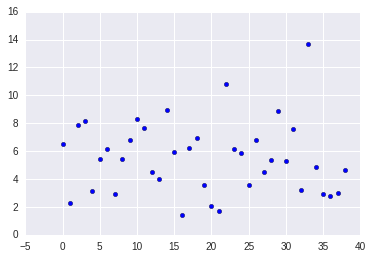

In [151]:
plt.scatter(range(0, 39), per_class_log_loss) # TODO: label axes, words on the x axis.
plt.show()

Let's not get bogged down in the details... why did we have to flip the columns in binary predictions? Otherwise, the values we see on this plot make sense.

It looks like our NB model is worst at predicting class 33 (TREA) and 22 (PORNOGRAHY/OBSCENE MAT) and is the best at predicting the most common classes 16 (LARCENY/THEFT) and 1 (ASSAULT). Classes 33 and 22 also happen to be the categories with the least amount of incidents in the training dataset. 

The next steps would be to explore how these classes are different from the other classes, and find different ways to represent these data points to make better predictions. 

We could also find summary statistics for the per-class log loss (what's the average log loss value? etc).

log loss has been a tough error metric to grasp conceptually... I'm a bit shaky on what it means to have a high or low log loss score, comparing log loss scores to each other, and so on. 

In [154]:
labels[33], labels[22]

('TREA', 'PORNOGRAPHY/OBSCENE MAT')

### Visualizing the performance of our models

We could...
* Plot the log loss values of different classifiers
* Compare training performance vs. kaggle performance
* Compare classifiers with different hyperparameter values used